In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%pip install PyArabic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 1.4 MB/s eta 0:00:00


In [ ]:
!pip install gensim

# Data Cleaning and Pre-processing

**Data Cleaning**

In [ ]:
import pandas as pd
import re
from pyarabic import araby

# Open the file
df = pd.read_csv('630.csv', encoding='utf-8-sig')

# Remove Tashkeel from Arabic text using araby library
df['col2'] = df['col2'].apply(lambda x: araby.strip_tashkeel(x) if isinstance(x, str) else x)

# Remove English letters and numbers
df['col2'] = df['col2'].str.replace(r'[A-Za-z0-9]+', ' ')

#remove symbols
df['col2'] = df['col2'].str.replace(r'[^\w\s]', ' ')

#remove the blank rows
df.dropna(how='all', inplace=True)

#remove lines in each cell
df['col2'] = df['col2'].str.replace('\n', ' ')

#remove multi-spaces in each cell
df['col2'] = df['col2'].apply(lambda x: re.sub('\s+', ' ', x) if isinstance(x, str) else x)

# Save data to a new CSV file
df.to_csv('cleaned_phase2_dataset.csv', encoding='utf-8-sig', index=False)


<ipython-input-9-90dbea6f656c>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df['col2'] = df['col2'].str.replace(r'[A-Za-z0-9]+', ' ')
<ipython-input-9-90dbea6f656c>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df['col2'] = df['col2'].str.replace(r'[^\w\s]', ' ')


**Data Preprocessing**

In [ ]:
#stop words removal
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Get NLTK's Arabic stop words
nltk_stop_words = set(stopwords.words('arabic'))

# Define our custom stop words
custom_stop_words = {"أولا", "ثانيا", "ثالثا", "رابعا", "خامسا", "سادسا", "سابعا",
                     "ثامنا", "تاسعا", "عاشرا", "البند", "الأول", "الثاني", "الثالث",
                     "الرابع", "الخامس", "السادس", "السابع", "الثامن", "التاسع", "العاشر",
                      "أية", "ومع", "إنها", "يلي", "إننا", "لدينا", "منك",
                     "إليها", "تم", "يدل", "وذلك","يعني","يبين",
                     "١٠", "٣", "٢","١","٠","٩", "٨", "٧", "٦","٥","٤", "أو","على","أي","عبر","لأي"}

# Combine the NLTK stop words with our custom stop words
stop_words = nltk_stop_words.union(custom_stop_words)

# Read the CSV file into a DataFrame
df = pd.read_csv('cleaned_phase2_dataset.csv', encoding='utf-8-sig')

# Apply stop words removal to the second column ('col2' in this example)
df['col2'] = df['col2'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Save the modified DataFrame to a new CSV file with UTF-8 encoding
df.to_csv('phase2_dataset_with_ stop_words.csv', encoding='utf-8-sig', index=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#normalization
df = pd.read_csv('phase2_dataset_with_ stop_words.csv', encoding='utf-8-sig')

df['col2'] = df['col2'].apply(lambda x: re.sub("[إأٱآا]", "ا", x) if isinstance(x, str) else x)
df['col2'] = df['col2'].apply(lambda x: re.sub("[ؤو]","و", x) if isinstance(x, str) else x)
df['col2'] = df['col2'].apply(lambda x: re.sub("[ئى]","ي", x) if isinstance(x, str) else x)
df['col2'] = df['col2'].apply(lambda x: re.sub("[ة]","ه", x) if isinstance(x, str) else x)

# Save data to a new CSV file
df.to_csv('final_phase_dataset_with_stop_words.csv', encoding='utf-8-sig', index=False)



# Phase-1: Initial Experiment and Baseline Models

# Machine Learning Models TF-IDF

**TF-IDF Logistic Regression**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
data = pd.read_csv('final_BR_dataset_with_stop_words.csv')

# Define the feature and target variables
X = data['col2']
label_cols = ['Label1', 'Label2', 'Label3', 'Label4', 'Label5', 'Label6', 'Label7', 'Label8', 'Label9']
y = data[label_cols]

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Initialize the OneVsRestClassifier with Logistic Regression
classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear'))

# Define KFold cross-validator
kf = KFold(n_splits=7, random_state=42, shuffle=True)

# To store the F1 scores, precision, and recall for each label and their micro averages
f1_scores_labels = {label: [] for label in label_cols}
precision_scores_labels = {label: [] for label in label_cols}
recall_scores_labels = {label: [] for label in label_cols}
micro_f1_scores = []
micro_precision_scores = []
micro_recall_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X):
    # Split data
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    # Transform the text data to TF-IDF features
    X_train_vec = vectorizer.fit_transform(X_train_kf)
    X_test_vec = vectorizer.transform(X_test_kf)

    # Fit the classifier
    classifier.fit(X_train_vec, y_train_kf)

    # Predict on the validation set
    y_pred_kf = classifier.predict(X_test_vec)

    # Calculate metrics
    micro_f1 = f1_score(y_test_kf, y_pred_kf, average='micro')
    micro_precision = precision_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)
    micro_recall = recall_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)

    micro_f1_scores.append(micro_f1)
    micro_precision_scores.append(micro_precision)
    micro_recall_scores.append(micro_recall)

    for label_index, label in enumerate(label_cols):
        f1 = f1_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        precision = precision_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        recall = recall_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)

        f1_scores_labels[label].append(f1)
        precision_scores_labels[label].append(precision)
        recall_scores_labels[label].append(recall)

# Calculate and print the average metrics for each label
for label in label_cols:
    average_f1_score = np.mean(f1_scores_labels[label])
    average_precision_score = np.mean(precision_scores_labels[label])
    average_recall_score = np.mean(recall_scores_labels[label])

    print(f"Average F1 Score for {label}: {average_f1_score}")
    print(f"Average Precision Score for {label}: {average_precision_score}")
    print(f"Average Recall Score for {label}: {average_recall_score}")

# Calculate and print the average micro metrics across all cross-validation folds
average_micro_f1_score = np.mean(micro_f1_scores)
average_micro_precision_score = np.mean(micro_precision_scores)
average_micro_recall_score = np.mean(micro_recall_scores)

print(f"Average Micro F1 Score: {average_micro_f1_score}")
print(f"Average Micro Precision Score: {average_micro_precision_score}")
print(f"Average Micro Recall Score: {average_micro_recall_score}")


Average F1 Score for Label1: 0.8584008899053671
Average Precision Score for Label1: 0.7755441074341257
Average Recall Score for Label1: 0.9632160567427198
Average F1 Score for Label2: 0.9546241613765124
Average Precision Score for Label2: 0.9156630055168533
Average Recall Score for Label2: 0.9978354978354977
Average F1 Score for Label3: 0.46990262785263764
Average Precision Score for Label3: 0.7412680305031872
Average Recall Score for Label3: 0.35218670305879607
Average F1 Score for Label4: 0.8792895373947623
Average Precision Score for Label4: 0.7984899081457622
Average Recall Score for Label4: 0.9790116899053186
Average F1 Score for Label5: 0.9348312475221398
Average Precision Score for Label5: 0.8782495018486312
Average Recall Score for Label5: 1.0
Average F1 Score for Label6: 0.7248061474054112
Average Precision Score for Label6: 0.8571751104669741
Average Recall Score for Label6: 0.6308407064564701
Average F1 Score for Label7: 0.5679075163419586
Average Precision Score for Label7:

**TF-IDF Random Forest**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
data = pd.read_csv('final_BR_dataset_with_stop_words.csv')

# Define the feature and target variables
X = data['col2']
label_cols = ['Label1', 'Label2', 'Label3', 'Label4', 'Label5', 'Label6', 'Label7', 'Label8', 'Label9']
y = data[label_cols]

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Initialize the OneVsRestClassifier with Random Forest
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=500, random_state=42))

# Define KFold cross-validator
kf = KFold(n_splits=7, random_state=42, shuffle=True)

# To store the F1 scores for each label and micro F1 scores
f1_scores_labels = {label: [] for label in label_cols}
precision_scores_labels = {label: [] for label in label_cols}
recall_scores_labels = {label: [] for label in label_cols}
micro_f1_scores = []
micro_precision_scores = []
micro_recall_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X):
    # Split data
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    # Transform the text data to TF-IDF features
    X_train_vec = vectorizer.fit_transform(X_train_kf)
    X_test_vec = vectorizer.transform(X_test_kf)

    # Fit the classifier
    classifier.fit(X_train_vec, y_train_kf)

    # Predict on the validation set
    y_pred_kf = classifier.predict(X_test_vec)

    # Calculate the micro F1 score and append to the list
    micro_f1 = f1_score(y_test_kf, y_pred_kf, average='micro')
    micro_precision = precision_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)
    micro_recall = recall_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)

    micro_f1_scores.append(micro_f1)
    micro_precision_scores.append(micro_precision)
    micro_recall_scores.append(micro_recall)

    for label_index, label in enumerate(label_cols):
        f1 = f1_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        precision = precision_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        recall = recall_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)

        f1_scores_labels[label].append(f1)
        precision_scores_labels[label].append(precision)
        recall_scores_labels[label].append(recall)

# Calculate and print the average metrics for each label
for label in label_cols:
    average_f1_score = np.mean(f1_scores_labels[label])
    average_precision_score = np.mean(precision_scores_labels[label])
    average_recall_score = np.mean(recall_scores_labels[label])

    print(f"Average F1 Score for {label}: {average_f1_score}")
    print(f"Average Precision Score for {label}: {average_precision_score}")
    print(f"Average Recall Score for {label}: {average_recall_score}")

# Calculate and print the average micro metrics across all cross-validation folds
average_micro_f1_score = np.mean(micro_f1_scores)
average_micro_precision_score = np.mean(micro_precision_scores)
average_micro_recall_score = np.mean(micro_recall_scores)

print(f"Average Micro F1 Score: {average_micro_f1_score}")
print(f"Average Micro Precision Score: {average_micro_precision_score}")
print(f"Average Micro Recall Score: {average_micro_recall_score}")

Average F1 Score for Label1: 0.8756872345885284
Average Precision Score for Label1: 0.8346902434865653
Average Recall Score for Label1: 0.9220217614471505
Average F1 Score for Label2: 0.9672826171630635
Average Precision Score for Label2: 0.9426037691622504
Average Recall Score for Label2: 0.9935535479013738
Average F1 Score for Label3: 0.5912438286266565
Average Precision Score for Label3: 0.713942598778642
Average Recall Score for Label3: 0.5134741724858004
Average F1 Score for Label4: 0.8963821292733811
Average Precision Score for Label4: 0.8349269638414178
Average Recall Score for Label4: 0.968449171398764
Average F1 Score for Label5: 0.9281651807668777
Average Precision Score for Label5: 0.8949509024188927
Average Recall Score for Label5: 0.9643444888595971
Average F1 Score for Label6: 0.7753723023669037
Average Precision Score for Label6: 0.8618879149937183
Average Recall Score for Label6: 0.7096918475613058
Average F1 Score for Label7: 0.6537813697699172
Average Precision Score 

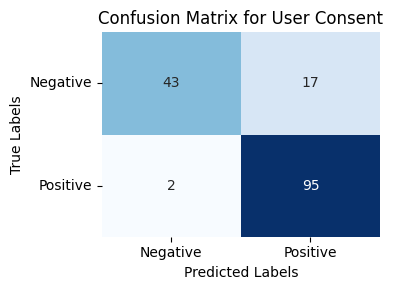

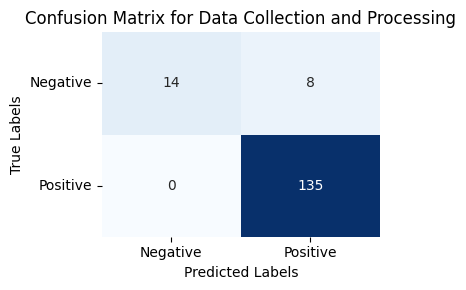

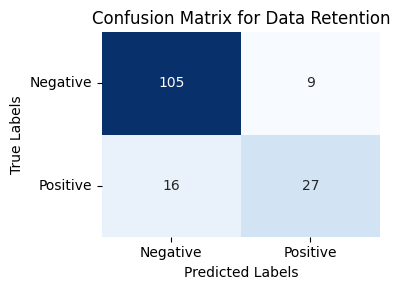

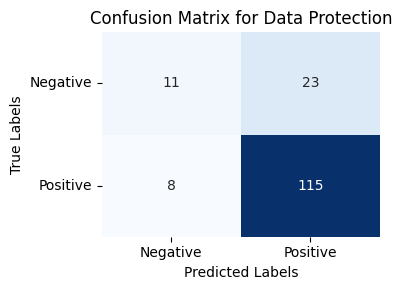

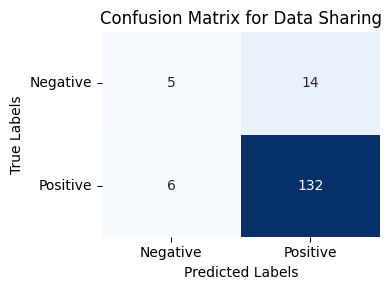

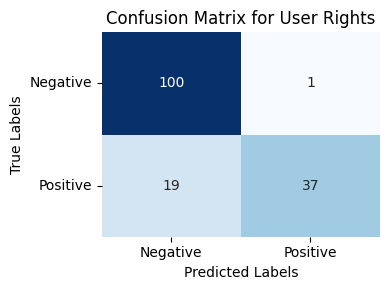

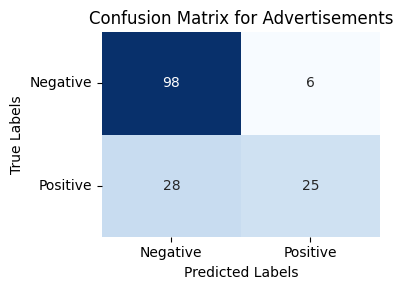

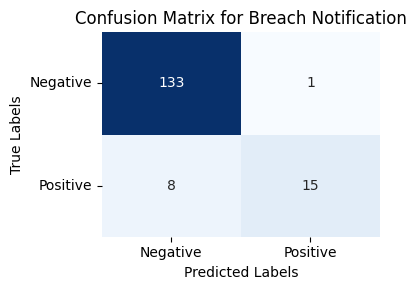

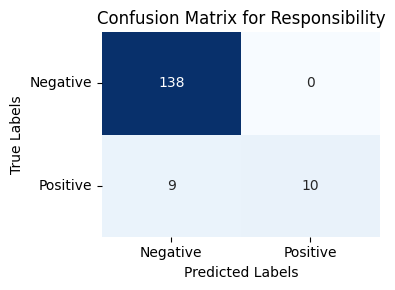

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'y_test_kf' are the true labels and 'y_pred_kf' are the predicted labels from your SVM classifier

# Calculate confusion matrices for each label
multilabel_cms = multilabel_confusion_matrix(y_test_kf, y_pred_kf)

# List of descriptive label names
label_names = [
    "User Consent",
    "Data Collection and Processing",
    "Data Retention",
    "Data Protection",
    "Data Sharing",
    "User Rights",
    "Advertisements",
    "Breach Notification",
    "Responsibility"
]

# Plotting heatmaps for each label's confusion matrix
for i, label_name in enumerate(label_names):
    plt.figure(figsize=(4, 3))  # Adjusted figure size for better readability
    sns.heatmap(multilabel_cms[i], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {label_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks([0.5, 1.5], labels=['Negative', 'Positive'])  # Adjust labels as needed
    plt.yticks([0.5, 1.5], labels=['Negative', 'Positive'], rotation=0)  # Adjust rotation and labels
    plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
    plt.show()


In [ ]:
# Number of examples to print
n_examples = 5

# Iterate over the folds
for train_index, test_index in kf.split(X):
    examples_printed = 0  # Reset for each fold
    # Split data
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    # Transform the text data to TF-IDF features
    X_train_vec = vectorizer.fit_transform(X_train_kf)
    X_test_vec = vectorizer.transform(X_test_kf)

    # Fit the classifier
    classifier.fit(X_train_vec, y_train_kf)

    # Predict on the validation set
    y_pred_kf = classifier.predict(X_test_vec)

    # Iterate over the test set for the current fold
    for i, index in enumerate(test_index):
        # Only print n_examples
        if examples_printed >= n_examples:
            break

        # Select the i-th test example
        true_labels = y_test_kf.iloc[i, :]
        predicted_labels = y_pred_kf[i, :]

        # Check if the prediction does not match the true labels
        if not np.array_equal(true_labels, predicted_labels):
            print(f"Row Index: {index}")
            print(f"Text: {X_test_kf.iloc[i]}")
            print(f"True Labels: {true_labels.tolist()}")
            print(f"Pred Labels: {predicted_labels.tolist()}")
            print("\n")
            examples_printed += 1

Row Index: 10
Text: جمع المعلومات وتطبيقها تنطبق السياسه بيانات جمعها باي وسيله جمع تشمل سبيل المثال الحصر بيانات التعريف الشخصيه تقدمها كعميل مباشره بالاضافه البيانات يتم جمعها خلال التعرف استخدامك لتطبيقنا وخدماتنا البيانات الشخصيه تسمح بفهم وتحسين تشغيل خدماتنا تجمع معلومات التعريف الشخصيه تقدمها طواعيه اثناء استخدام خدمات وعلي النحو المتفق شروط واحكام تجمع معلومات حول سلوك معاملات العملاء تفاصيل حسابات بنكيه مستخدمه لحمايه البيانات ستبذل قصاري جهدها للتاكد المعلومات المقدمه العميل تظل وتستخدم فقط للغرض تقديمها اجله تتبع متطلبات اطار عمل الامن السيبراني الخاصه بالمملكه جنبا جنب موسسه النقد العربي السعودي ومعايير هييه الامن السيبراني لتوفير اقصي قدر الحمايه والخصوصيه لبياناتك استخدام التشفير ومراقبه انظمتنا بانتظام بحثا نقاط الضعف والهجمات المحتمله ستتم حمايه معاملات دفع وحمايتها طريق التشفير يمكننا ضمان امان بيانات ترسلها الينا يضمن عدم امكانيه الوصول البيانات الكشف عنها تغييرها اتلافها طريق الاختراق لان الانترنت امنا تماما افشاء لبيانات العملاء بالاقرار بهذه السياسه يجوز الكشف بيان

**TF-IDF Support Vector Machine**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
data = pd.read_csv('final_BR_dataset_with_stop_words.csv')

# Define the feature and target variables
X = data['col2']
label_cols = ['Label1', 'Label2', 'Label3', 'Label4', 'Label5', 'Label6', 'Label7', 'Label8', 'Label9']
y = data[label_cols]

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Initialize the OneVsRestClassifier with SVC
classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42))

# Define KFold cross-validator
kf = KFold(n_splits=7, random_state=42, shuffle=True)

# To store metrics
f1_scores_labels = {label: [] for label in label_cols}
precision_scores_labels = {label: [] for label in label_cols}
recall_scores_labels = {label: [] for label in label_cols}
micro_f1_scores = []
micro_precision_scores = []
micro_recall_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    X_train_vec = vectorizer.fit_transform(X_train_kf)
    X_test_vec = vectorizer.transform(X_test_kf)

    classifier.fit(X_train_vec, y_train_kf)

    y_pred_kf = classifier.predict(X_test_vec)

    # Calculate micro metrics and append to their lists
    micro_f1 = f1_score(y_test_kf, y_pred_kf, average='micro')
    micro_precision = precision_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)
    micro_recall = recall_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)
    micro_f1_scores.append(micro_f1)
    micro_precision_scores.append(micro_precision)
    micro_recall_scores.append(micro_recall)

    # Calculate metrics for each label and append to their lists
    for label_index, label in enumerate(label_cols):
        f1 = f1_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        precision = precision_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        recall = recall_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)

        f1_scores_labels[label].append(f1)
        precision_scores_labels[label].append(precision)
        recall_scores_labels[label].append(recall)

# After the loop, calculate and print averages for each metric
for label in label_cols:
    average_f1_score = np.mean(f1_scores_labels[label])
    average_precision_score = np.mean(precision_scores_labels[label])
    average_recall_score = np.mean(recall_scores_labels[label])

    print(f"Average F1 Score for {label}: {average_f1_score}")
    print(f"Average Precision Score for {label}: {average_precision_score}")
    print(f"Average Recall Score for {label}: {average_recall_score}")

average_micro_f1_score = np.mean(micro_f1_scores)
average_micro_precision_score = np.mean(micro_precision_scores)
average_micro_recall_score = np.mean(micro_recall_scores)

print(f"Average Micro F1 Score: {average_micro_f1_score}")
print(f"Average Micro Precision Score: {average_micro_precision_score}")
print(f"Average Micro Recall Score: {average_micro_recall_score}")


Average F1 Score for Label1: 0.8718381074879024
Average Precision Score for Label1: 0.8226317604907659
Average Recall Score for Label1: 0.9289043629726093
Average F1 Score for Label2: 0.9667201698573961
Average Precision Score for Label2: 0.9425939039420738
Average Recall Score for Label2: 0.9924239386297273
Average F1 Score for Label3: 0.5829219491162948
Average Precision Score for Label3: 0.7049067813898047
Average Recall Score for Label3: 0.504794770492445
Average F1 Score for Label4: 0.8906731380112872
Average Precision Score for Label4: 0.8349325083704328
Average Recall Score for Label4: 0.9553920678034205
Average F1 Score for Label5: 0.9384728204644918
Average Precision Score for Label5: 0.890500444707547
Average Recall Score for Label5: 0.9926465087727767
Average F1 Score for Label6: 0.7780987521719718
Average Precision Score for Label6: 0.8341450662794173
Average Recall Score for Label6: 0.7357157392871679
Average F1 Score for Label7: 0.6576670064233464
Average Precision Score 

# Macine Learning Models Word2vec

**word2vec Logistic Regression**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score
from gensim.models import Word2Vec

# Load the dataset
data = pd.read_csv('final_BR_dataset_with_stop_words.csv')

# Define the feature and target variables
X = data['col2']
label_cols = ['Label1', 'Label2', 'Label3', 'Label4', 'Label5', 'Label6', 'Label7', 'Label8', 'Label9']
y = data[label_cols]

# Prepare the text data for Word2Vec
sentences = [row.split() for row in X]

# Train a Word2Vec model (consider using a pre-trained model for better performance)
model = Word2Vec(sentences, vector_size=300, window=10, min_count=1, workers=4)

def document_vector(doc):
    """Create a document vector by averaging the Word2Vec vectors of its words."""
    words = doc.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(word_vectors, axis=0)

# Vectorize the documents using the document vector function
X_vec = np.array([document_vector(doc) for doc in X])

# Initialize the OneVsRestClassifier with Logistic Regression
classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear'))

# Define KFold cross-validator
kf = KFold(n_splits=7, random_state=42, shuffle=True)

# To store the F1 scores, precision, and recall for each label and their micro averages
f1_scores_labels = {label: [] for label in label_cols}
precision_scores_labels = {label: [] for label in label_cols}
recall_scores_labels = {label: [] for label in label_cols}
micro_f1_scores = []
micro_precision_scores = []
micro_recall_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X_vec):
    X_train_kf, X_test_kf = X_vec[train_index], X_vec[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    # Fit the classifier
    classifier.fit(X_train_kf, y_train_kf)

    # Predict on the validation set
    y_pred_kf = classifier.predict(X_test_kf)

    # Calculate metrics
    micro_f1 = f1_score(y_test_kf, y_pred_kf, average='micro')
    micro_precision = precision_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)
    micro_recall = recall_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)

    micro_f1_scores.append(micro_f1)
    micro_precision_scores.append(micro_precision)
    micro_recall_scores.append(micro_recall)

    for label_index, label in enumerate(label_cols):
        f1 = f1_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        precision = precision_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        recall = recall_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)

        f1_scores_labels[label].append(f1)
        precision_scores_labels[label].append(precision)
        recall_scores_labels[label].append(recall)

# Calculate and print the average metrics for each label
for label in label_cols:
    average_f1_score = np.mean(f1_scores_labels[label])
    average_precision_score = np.mean(precision_scores_labels[label])
    average_recall_score = np.mean(recall_scores_labels[label])

    print(f"Average F1 Score for {label}: {average_f1_score}")
    print(f"Average Precision Score for {label}: {average_precision_score}")
    print(f"Average Recall Score for {label}: {average_recall_score}")

# Calculate and print the average micro metrics across all cross-validation folds
average_micro_f1_score = np.mean(micro_f1_scores)
average_micro_precision_score = np.mean(micro_precision_scores)
average_micro_recall_score = np.mean(micro_recall_scores)

print(f"Average Micro F1 Score: {average_micro_f1_score}")
print(f"Average Micro Precision Score: {average_micro_precision_score}")
print(f"Average Micro Recall Score: {average_micro_recall_score}")


Average F1 Score for Label1: 0.8538615829295733
Average Precision Score for Label1: 0.8069846432030913
Average Recall Score for Label1: 0.9085925893158258
Average F1 Score for Label2: 0.9685879233628609
Average Precision Score for Label2: 0.9499771842866249
Average Recall Score for Label2: 0.9882341396665704
Average F1 Score for Label3: 0.3076576051575112
Average Precision Score for Label3: 0.5823329331732693
Average Recall Score for Label3: 0.2143699123350286
Average F1 Score for Label4: 0.8821359719922628
Average Precision Score for Label4: 0.828818671669014
Average Recall Score for Label4: 0.9437848821062708
Average F1 Score for Label5: 0.9365078516065978
Average Precision Score for Label5: 0.8835187628812332
Average Recall Score for Label5: 0.997009148486981
Average F1 Score for Label6: 0.6811621774215759
Average Precision Score for Label6: 0.7449184567659218
Average Recall Score for Label6: 0.6327174194169268
Average F1 Score for Label7: 0.5598792892688159
Average Precision Score 

**word2vec Random Forest**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score
from gensim.models import Word2Vec

# Load the dataset
data = pd.read_csv('final_BR_dataset_with_stop_words.csv')

# Define the feature and target variables
X = data['col2']
label_cols = ['Label1', 'Label2', 'Label3', 'Label4', 'Label5', 'Label6', 'Label7', 'Label8', 'Label9']
y = data[label_cols]

# Prepare the text data for Word2Vec
sentences = [row.split() for row in X]

# Train a Word2Vec model (consider using a pre-trained model for better performance)
model = Word2Vec(sentences, vector_size=300, window=10, min_count=1, workers=4)

def document_vector(doc):
    """Create a document vector by averaging the Word2Vec vectors of its words."""
    words = doc.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(word_vectors, axis=0)

# Vectorize the documents using the document vector function
X_vec = np.array([document_vector(doc) for doc in X])

# Initialize the OneVsRestClassifier with Random Forest
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=500, random_state=42))

# Define KFold cross-validator
kf = KFold(n_splits=7, random_state=42, shuffle=True)

# To store the F1 scores, precision, and recall for each label and their micro averages
f1_scores_labels = {label: [] for label in label_cols}
precision_scores_labels = {label: [] for label in label_cols}
recall_scores_labels = {label: [] for label in label_cols}
micro_f1_scores = []
micro_precision_scores = []
micro_recall_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X_vec):
    X_train_kf, X_test_kf = X_vec[train_index], X_vec[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    # Fit the classifier
    classifier.fit(X_train_kf, y_train_kf)

    # Predict on the validation set
    y_pred_kf = classifier.predict(X_test_kf)

    # Calculate metrics
    micro_f1 = f1_score(y_test_kf, y_pred_kf, average='micro')
    micro_precision = precision_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)
    micro_recall = recall_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)

    micro_f1_scores.append(micro_f1)
    micro_precision_scores.append(micro_precision)
    micro_recall_scores.append(micro_recall)

    for label_index, label in enumerate(label_cols):
        f1 = f1_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        precision = precision_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        recall = recall_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)

        f1_scores_labels[label].append(f1)
        precision_scores_labels[label].append(precision)
        recall_scores_labels[label].append(recall)

# Calculate and print the average metrics for each label
for label in label_cols:
    average_f1_score = np.mean(f1_scores_labels[label])
    average_precision_score = np.mean(precision_scores_labels[label])
    average_recall_score = np.mean(recall_scores_labels[label])

    print(f"Average F1 Score for {label}: {average_f1_score}")
    print(f"Average Precision Score for {label}: {average_precision_score}")
    print(f"Average Recall Score for {label}: {average_recall_score}")

# Calculate and print the average micro metrics across all cross-validation folds
average_micro_f1_score = np.mean(micro_f1_scores)
average_micro_precision_score = np.mean(micro_precision_scores)
average_micro_recall_score = np.mean(micro_recall_scores)

print(f"Average Micro F1 Score: {average_micro_f1_score}")
print(f"Average Micro Precision Score: {average_micro_precision_score}")
print(f"Average Micro Recall Score: {average_micro_recall_score}")


Average F1 Score for Label1: 0.8775777601019948
Average Precision Score for Label1: 0.8462173835731365
Average Recall Score for Label1: 0.9118065913428702
Average F1 Score for Label2: 0.9736867352702524
Average Precision Score for Label2: 0.9606459674975242
Average Recall Score for Label2: 0.9873373321419792
Average F1 Score for Label3: 0.5454827203385948
Average Precision Score for Label3: 0.6894235280319024
Average Recall Score for Label3: 0.4555076671355741
Average F1 Score for Label4: 0.8998756926300925
Average Precision Score for Label4: 0.8603233109213603
Average Recall Score for Label4: 0.943924598961729
Average F1 Score for Label5: 0.9470133014618456
Average Precision Score for Label5: 0.9119651593090639
Average Recall Score for Label5: 0.9855019200041746
Average F1 Score for Label6: 0.7257141114780932
Average Precision Score for Label6: 0.8123287191550373
Average Recall Score for Label6: 0.6600618821062171
Average F1 Score for Label7: 0.660099806066414
Average Precision Score 

**Word2vec Support Vector Machine**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score
from gensim.models import Word2Vec

# Load the dataset
data = pd.read_csv('final_BR_dataset_with_stop_words.csv')

# Define the feature and target variables
X = data['col2']
label_cols = ['Label1', 'Label2', 'Label3', 'Label4', 'Label5', 'Label6', 'Label7', 'Label8', 'Label9']
y = data[label_cols]

# Prepare the text data for Word2Vec
sentences = [row.split() for row in X]

# Train a Word2Vec model
model = Word2Vec(sentences, vector_size=300, window=10, min_count=1, workers=4)

def document_vector(doc):
    """Create a document vector by averaging the Word2Vec vectors of its words."""
    words = doc.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(word_vectors, axis=0)

# Vectorize the documents using the document vector function
X_vec = np.array([document_vector(doc) for doc in X])

# Initialize the OneVsRestClassifier with SVC
classifier = OneVsRestClassifier(SVC(kernel='linear',  probability=True, random_state=42))

# Define KFold cross-validator
kf = KFold(n_splits=7, random_state=42, shuffle=True)

# To store the F1 scores, precision, and recall for each label and their micro averages
f1_scores_labels = {label: [] for label in label_cols}
precision_scores_labels = {label: [] for label in label_cols}
recall_scores_labels = {label: [] for label in label_cols}
micro_f1_scores = []
micro_precision_scores = []
micro_recall_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X_vec):
    X_train_kf, X_test_kf = X_vec[train_index], X_vec[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    # Fit the classifier
    classifier.fit(X_train_kf, y_train_kf)

    # Predict on the validation set
    y_pred_kf = classifier.predict(X_test_kf)

    # Calculate metrics
    micro_f1 = f1_score(y_test_kf, y_pred_kf, average='micro')
    micro_precision = precision_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)
    micro_recall = recall_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)

    micro_f1_scores.append(micro_f1)
    micro_precision_scores.append(micro_precision)
    micro_recall_scores.append(micro_recall)

    for label_index, label in enumerate(label_cols):
        f1 = f1_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        precision = precision_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        recall = recall_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)

        f1_scores_labels[label].append(f1)
        precision_scores_labels[label].append(precision)
        recall_scores_labels[label].append(recall)

# Calculate and print the average metrics for each label
for label in label_cols:
    average_f1_score = np.mean(f1_scores_labels[label])
    average_precision_score = np.mean(precision_scores_labels[label])
    average_recall_score = np.mean(recall_scores_labels[label])

    print(f"Average F1 Score for {label}: {average_f1_score}")
    print(f"Average Precision Score for {label}: {average_precision_score}")
    print(f"Average Recall Score for {label}: {average_recall_score}")

# Calculate and print the average micro metrics across all cross-validation folds
average_micro_f1_score = np.mean(micro_f1_scores)
average_micro_precision_score = np.mean(micro_precision_scores)
average_micro_recall_score = np.mean(micro_recall_scores)

print(f"Average Micro F1 Score: {average_micro_f1_score}")
print(f"Average Micro Precision Score: {average_micro_precision_score}")
print(f"Average Micro Recall Score: {average_micro_recall_score}")


Average F1 Score for Label1: 0.8598607878228309
Average Precision Score for Label1: 0.8071939887195932
Average Recall Score for Label1: 0.9214360444548907
Average F1 Score for Label2: 0.9681837848349356
Average Precision Score for Label2: 0.9463045814400884
Average Recall Score for Label2: 0.9913637130089097
Average F1 Score for Label3: 0.15165613768769978
Average Precision Score for Label3: 0.6207482993197279
Average Recall Score for Label3: 0.0892835366672576
Average F1 Score for Label4: 0.8868161011819129
Average Precision Score for Label4: 0.8244547162401782
Average Recall Score for Label4: 0.9601269554575541
Average F1 Score for Label5: 0.9348312475221398
Average Precision Score for Label5: 0.8782495018486312
Average Recall Score for Label5: 1.0
Average F1 Score for Label6: 0.6742094151523534
Average Precision Score for Label6: 0.7272441577248939
Average Recall Score for Label6: 0.6348635696542101
Average F1 Score for Label7: 0.5618716618521623
Average Precision Score for Label7: 

# Phase-2: Synthetic Data Augmentation and Class Balancing

# Machine Learning Models TF-IDF

**TF-IDF Logistic Regression**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
data = pd.read_csv('Phase2.csv')

# Define the feature and target variables
X = data['col1']
label_cols = ['Label1', 'Label2', 'Label3', 'Label4', 'Label5', 'Label6', 'Label7', 'Label8', 'Label9']
y = data[label_cols]

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Initialize the OneVsRestClassifier with Logistic Regression
classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear'))

# Define KFold cross-validator
kf = KFold(n_splits=7, random_state=42, shuffle=True)

# To store the F1 scores, precision, and recall for each label and their micro averages
f1_scores_labels = {label: [] for label in label_cols}
precision_scores_labels = {label: [] for label in label_cols}
recall_scores_labels = {label: [] for label in label_cols}
micro_f1_scores = []
micro_precision_scores = []
micro_recall_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X):
    # Split data
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    # Transform the text data to TF-IDF features
    X_train_vec = vectorizer.fit_transform(X_train_kf)
    X_test_vec = vectorizer.transform(X_test_kf)

    # Fit the classifier
    classifier.fit(X_train_vec, y_train_kf)

    # Predict on the validation set
    y_pred_kf = classifier.predict(X_test_vec)

    # Calculate metrics
    micro_f1 = f1_score(y_test_kf, y_pred_kf, average='micro')
    micro_precision = precision_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)
    micro_recall = recall_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)

    micro_f1_scores.append(micro_f1)
    micro_precision_scores.append(micro_precision)
    micro_recall_scores.append(micro_recall)

    for label_index, label in enumerate(label_cols):
        f1 = f1_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        precision = precision_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        recall = recall_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)

        f1_scores_labels[label].append(f1)
        precision_scores_labels[label].append(precision)
        recall_scores_labels[label].append(recall)

# Calculate and print the average metrics for each label
for label in label_cols:
    average_f1_score = np.mean(f1_scores_labels[label])
    average_precision_score = np.mean(precision_scores_labels[label])
    average_recall_score = np.mean(recall_scores_labels[label])

    print(f"Average F1 Score for {label}: {average_f1_score}")
    print(f"Average Precision Score for {label}: {average_precision_score}")
    print(f"Average Recall Score for {label}: {average_recall_score}")

# Calculate and print the average micro metrics across all cross-validation folds
average_micro_f1_score = np.mean(micro_f1_scores)
average_micro_precision_score = np.mean(micro_precision_scores)
average_micro_recall_score = np.mean(micro_recall_scores)

print(f"Average Micro F1 Score: {average_micro_f1_score}")
print(f"Average Micro Precision Score: {average_micro_precision_score}")
print(f"Average Micro Recall Score: {average_micro_recall_score}")


Average F1 Score for Label1: 0.8760508292779389
Average Precision Score for Label1: 0.8562388599646388
Average Recall Score for Label1: 0.8970673536911429
Average F1 Score for Label2: 0.9573617358583174
Average Precision Score for Label2: 0.9479950443267497
Average Recall Score for Label2: 0.9670613403211403
Average F1 Score for Label3: 0.8430849655360557
Average Precision Score for Label3: 0.9056798439820979
Average Recall Score for Label3: 0.7910993419346635
Average F1 Score for Label4: 0.8631427007127951
Average Precision Score for Label4: 0.8365599773964628
Average Recall Score for Label4: 0.8930250233133823
Average F1 Score for Label5: 0.9268461697730623
Average Precision Score for Label5: 0.8824764069055886
Average Recall Score for Label5: 0.9765730776471981
Average F1 Score for Label6: 0.8654215926775004
Average Precision Score for Label6: 0.8849220630153806
Average Recall Score for Label6: 0.8485541506064642
Average F1 Score for Label7: 0.8341190479652393
Average Precision Scor

**TF-IDF Random Forest**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
data = pd.read_csv('Phase2.csv')

# Define the feature and target variables
X = data['col1']
label_cols = ['Label1', 'Label2', 'Label3', 'Label4', 'Label5', 'Label6', 'Label7', 'Label8', 'Label9']
y = data[label_cols]

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Initialize the OneVsRestClassifier with Random Forest
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=500, random_state=42))

# Define KFold cross-validator
kf = KFold(n_splits=7, random_state=42, shuffle=True)

# To store the F1 scores for each label and micro F1 scores
f1_scores_labels = {label: [] for label in label_cols}
precision_scores_labels = {label: [] for label in label_cols}
recall_scores_labels = {label: [] for label in label_cols}
micro_f1_scores = []
micro_precision_scores = []
micro_recall_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X):
    # Split data
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    # Transform the text data to TF-IDF features
    X_train_vec = vectorizer.fit_transform(X_train_kf)
    X_test_vec = vectorizer.transform(X_test_kf)

    # Fit the classifier
    classifier.fit(X_train_vec, y_train_kf)

    # Predict on the validation set
    y_pred_kf = classifier.predict(X_test_vec)

    # Calculate the micro F1 score and append to the list
    micro_f1 = f1_score(y_test_kf, y_pred_kf, average='micro')
    micro_precision = precision_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)
    micro_recall = recall_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)

    micro_f1_scores.append(micro_f1)
    micro_precision_scores.append(micro_precision)
    micro_recall_scores.append(micro_recall)

    for label_index, label in enumerate(label_cols):
        f1 = f1_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        precision = precision_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        recall = recall_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)

        f1_scores_labels[label].append(f1)
        precision_scores_labels[label].append(precision)
        recall_scores_labels[label].append(recall)

# Calculate and print the average metrics for each label
for label in label_cols:
    average_f1_score = np.mean(f1_scores_labels[label])
    average_precision_score = np.mean(precision_scores_labels[label])
    average_recall_score = np.mean(recall_scores_labels[label])

    print(f"Average F1 Score for {label}: {average_f1_score}")
    print(f"Average Precision Score for {label}: {average_precision_score}")
    print(f"Average Recall Score for {label}: {average_recall_score}")

# Calculate and print the average micro metrics across all cross-validation folds
average_micro_f1_score = np.mean(micro_f1_scores)
average_micro_precision_score = np.mean(micro_precision_scores)
average_micro_recall_score = np.mean(micro_recall_scores)

print(f"Average Micro F1 Score: {average_micro_f1_score}")
print(f"Average Micro Precision Score: {average_micro_precision_score}")
print(f"Average Micro Recall Score: {average_micro_recall_score}")

Average F1 Score for Label1: 0.8895832575811922
Average Precision Score for Label1: 0.8609605287772005
Average Recall Score for Label1: 0.9215462175763098
Average F1 Score for Label2: 0.964518532731694
Average Precision Score for Label2: 0.9608304720808397
Average Recall Score for Label2: 0.9684454757946811
Average F1 Score for Label3: 0.8741099601944501
Average Precision Score for Label3: 0.8945980430908348
Average Recall Score for Label3: 0.8555623349429545
Average F1 Score for Label4: 0.8776390995520239
Average Precision Score for Label4: 0.8551120013069144
Average Recall Score for Label4: 0.9025098577750746
Average F1 Score for Label5: 0.9280817005313577
Average Precision Score for Label5: 0.9051210138975997
Average Recall Score for Label5: 0.9526449779524934
Average F1 Score for Label6: 0.8983573304843606
Average Precision Score for Label6: 0.8995450961283404
Average Recall Score for Label6: 0.8986065407146004
Average F1 Score for Label7: 0.8671374967544198
Average Precision Score

**TF-IDF Support Vector Machine**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
data = pd.read_csv('Phase2.csv')

# Define the feature and target variables
X = data['col1']
label_cols = ['Label1', 'Label2', 'Label3', 'Label4', 'Label5', 'Label6', 'Label7', 'Label8', 'Label9']
y = data[label_cols]

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Initialize the OneVsRestClassifier with SVC
classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42))

# Define KFold cross-validator
kf = KFold(n_splits=7, random_state=42, shuffle=True)

# To store metrics
f1_scores_labels = {label: [] for label in label_cols}
precision_scores_labels = {label: [] for label in label_cols}
recall_scores_labels = {label: [] for label in label_cols}
micro_f1_scores = []
micro_precision_scores = []
micro_recall_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    X_train_vec = vectorizer.fit_transform(X_train_kf)
    X_test_vec = vectorizer.transform(X_test_kf)

    classifier.fit(X_train_vec, y_train_kf)

    y_pred_kf = classifier.predict(X_test_vec)

    # Calculate micro metrics and append to their lists
    micro_f1 = f1_score(y_test_kf, y_pred_kf, average='micro')
    micro_precision = precision_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)
    micro_recall = recall_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)
    micro_f1_scores.append(micro_f1)
    micro_precision_scores.append(micro_precision)
    micro_recall_scores.append(micro_recall)

    # Calculate metrics for each label and append to their lists
    for label_index, label in enumerate(label_cols):
        f1 = f1_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        precision = precision_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        recall = recall_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)

        f1_scores_labels[label].append(f1)
        precision_scores_labels[label].append(precision)
        recall_scores_labels[label].append(recall)

# After the loop, calculate and print averages for each metric
for label in label_cols:
    average_f1_score = np.mean(f1_scores_labels[label])
    average_precision_score = np.mean(precision_scores_labels[label])
    average_recall_score = np.mean(recall_scores_labels[label])

    print(f"Average F1 Score for {label}: {average_f1_score}")
    print(f"Average Precision Score for {label}: {average_precision_score}")
    print(f"Average Recall Score for {label}: {average_recall_score}")

average_micro_f1_score = np.mean(micro_f1_scores)
average_micro_precision_score = np.mean(micro_precision_scores)
average_micro_recall_score = np.mean(micro_recall_scores)

print(f"Average Micro F1 Score: {average_micro_f1_score}")
print(f"Average Micro Precision Score: {average_micro_precision_score}")
print(f"Average Micro Recall Score: {average_micro_recall_score}")


Average F1 Score for Label1: 0.8922145492619276
Average Precision Score for Label1: 0.8666533835325897
Average Recall Score for Label1: 0.9200113846468901
Average F1 Score for Label2: 0.9665062708740871
Average Precision Score for Label2: 0.9554691290635345
Average Recall Score for Label2: 0.9778742792825806
Average F1 Score for Label3: 0.8615886209916932
Average Precision Score for Label3: 0.8918515131942597
Average Recall Score for Label3: 0.8357163701390066
Average F1 Score for Label4: 0.8830747914950786
Average Precision Score for Label4: 0.8385244574020084
Average Recall Score for Label4: 0.9338070039922901
Average F1 Score for Label5: 0.9376265380476844
Average Precision Score for Label5: 0.891624345809084
Average Recall Score for Label5: 0.9892907820831691
Average F1 Score for Label6: 0.8961129110235423
Average Precision Score for Label6: 0.8927029818767142
Average Recall Score for Label6: 0.901003222298414
Average F1 Score for Label7: 0.8656952819164891
Average Precision Score 

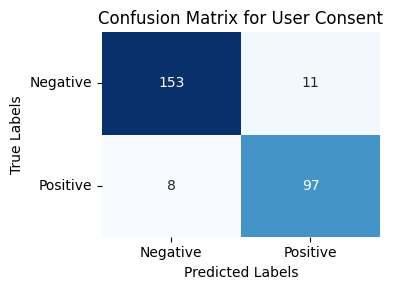

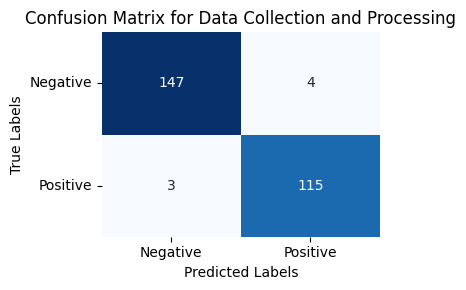

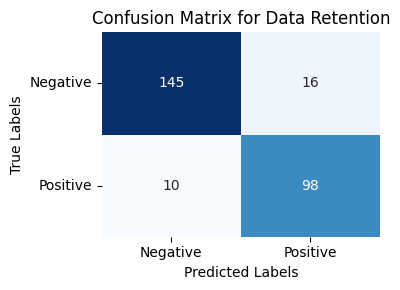

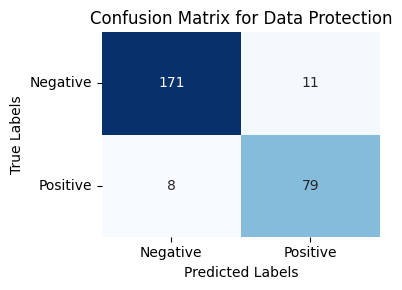

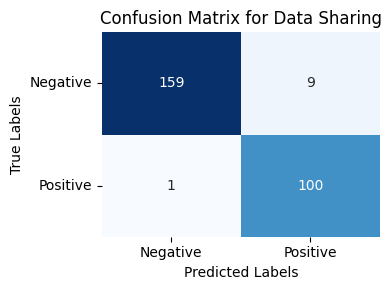

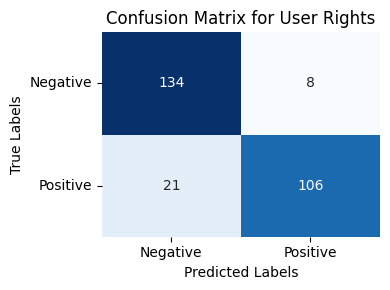

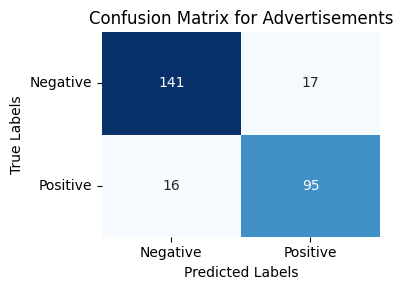

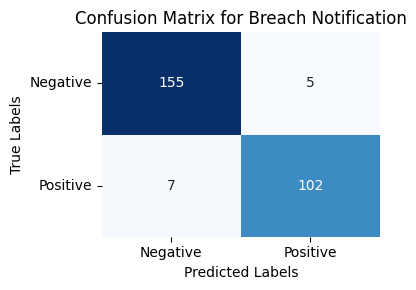

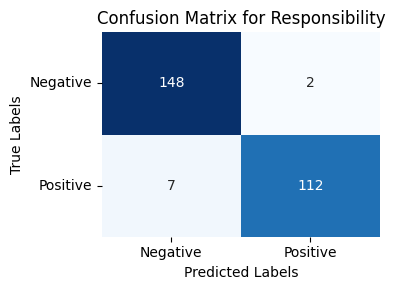

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'y_test_kf' are the true labels and 'y_pred_kf' are the predicted labels from your SVM classifier

# Calculate confusion matrices for each label
multilabel_cms = multilabel_confusion_matrix(y_test_kf, y_pred_kf)

# List of descriptive label names
label_names = [
    "User Consent",
    "Data Collection and Processing",
    "Data Retention",
    "Data Protection",
    "Data Sharing",
    "User Rights",
    "Advertisements",
    "Breach Notification",
    "Responsibility"
]

# Plotting heatmaps for each label's confusion matrix
for i, label_name in enumerate(label_names):
    plt.figure(figsize=(4, 3))  # Adjusted figure size for better readability
    sns.heatmap(multilabel_cms[i], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {label_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks([0.5, 1.5], labels=['Negative', 'Positive'])  # Adjust labels as needed
    plt.yticks([0.5, 1.5], labels=['Negative', 'Positive'], rotation=0)  # Adjust rotation and labels
    plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
    plt.show()


In [ ]:
# Number of examples to print
n_examples = 5

# Iterate over the folds
for train_index, test_index in kf.split(X):
    examples_printed = 0  # Reset for each fold
    # Split data
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    # Transform the text data to TF-IDF features
    X_train_vec = vectorizer.fit_transform(X_train_kf)
    X_test_vec = vectorizer.transform(X_test_kf)

    # Fit the classifier
    classifier.fit(X_train_vec, y_train_kf)

    # Predict on the validation set
    y_pred_kf = classifier.predict(X_test_vec)

    # Iterate over the test set for the current fold
    for i, index in enumerate(test_index):
        # Only print n_examples
        if examples_printed >= n_examples:
            break

        # Select the i-th test example
        true_labels = y_test_kf.iloc[i, :]
        predicted_labels = y_pred_kf[i, :]

        # Check if the prediction does not match the true labels
        if not np.array_equal(true_labels, predicted_labels):
            print(f"Row Index: {index}")
            print(f"Text: {X_test_kf.iloc[i]}")
            print(f"True Labels: {true_labels.tolist()}")
            print(f"Pred Labels: {predicted_labels.tolist()}")
            print("\n")
            examples_printed += 1

Row Index: 23
Text: تصميم الموقع الالكتروني للشركه وفق اعلي معايير الامن السيبراني المعمول دوليا المملكه العربيه السعوديه تحرص شركه فينزي للتمويل المصغر الحصول المعلومات الضروريه فقط لتلبيه احتياجات العملاء الخدمات الالكترونيه المقدمه عبر الموقع المعلومات الموجوده الموقع الالكتروني للشركه لغرض معلوماتي فقط ولايشكل عقد قانوني الشركه واي شخص جهه يحدد خلاف المعلومات المتوفره شركه فينزي للتمويل المصغر قابله للتغيير اشعار مسبق بالرغم اننا نبذل جهد لتحديث كافه المعلومات بصوره دايمه ودقيقه نستطيع نقدم ضمانات بذلك جمع واستخدام المعلومات الالكترونيه زياره موقعنا الالكتروني تقوم الشركه بالحصول معلومات شخصيه قمت باختيار خدمه التقديم الالكترونيه لاحد المنتجات زياراتك رسايل البريد الالكتروني رسايل البريد الالكتروني المرسله شركه فينزي للتمويل المصغر تعامل بنفس معامله الرسايل الخطيه ولن يتم مشاركه عناوين البريد الالكتروني يتم الحصول عليها الموقع الشركات الخاصه لاغراض تسويقيه نموذج الاقتراحات والشكاوي سيتم استخدام المعلومات المقدمه خلال النموذج فقط لتحسين خدمات شركه فينزي للتمويل المصغر وحل الشكاوي مع

# Machine Learning Models Word2vec

**Word2vec Logistic Regression**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score
from gensim.models import Word2Vec

# Load the dataset
data = pd.read_csv('Phase2.csv')

# Define the feature and target variables
X = data['col1']
label_cols = ['Label1', 'Label2', 'Label3', 'Label4', 'Label5', 'Label6', 'Label7', 'Label8', 'Label9']
y = data[label_cols]

# Prepare the text data for Word2Vec
sentences = [row.split() for row in X]

# Train a Word2Vec model (consider using a pre-trained model for better performance)
model = Word2Vec(sentences, vector_size=300, window=10, min_count=1, workers=4)

def document_vector(doc):
    """Create a document vector by averaging the Word2Vec vectors of its words."""
    words = doc.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(word_vectors, axis=0)

# Vectorize the documents using the document vector function
X_vec = np.array([document_vector(doc) for doc in X])

# Initialize the OneVsRestClassifier with Logistic Regression
classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear'))

# Define KFold cross-validator
kf = KFold(n_splits=7, random_state=42, shuffle=True)

# To store the F1 scores, precision, and recall for each label and their micro averages
f1_scores_labels = {label: [] for label in label_cols}
precision_scores_labels = {label: [] for label in label_cols}
recall_scores_labels = {label: [] for label in label_cols}
micro_f1_scores = []
micro_precision_scores = []
micro_recall_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X_vec):
    X_train_kf, X_test_kf = X_vec[train_index], X_vec[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    # Fit the classifier
    classifier.fit(X_train_kf, y_train_kf)

    # Predict on the validation set
    y_pred_kf = classifier.predict(X_test_kf)

    # Calculate metrics
    micro_f1 = f1_score(y_test_kf, y_pred_kf, average='micro')
    micro_precision = precision_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)
    micro_recall = recall_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)

    micro_f1_scores.append(micro_f1)
    micro_precision_scores.append(micro_precision)
    micro_recall_scores.append(micro_recall)

    for label_index, label in enumerate(label_cols):
        f1 = f1_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        precision = precision_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        recall = recall_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)

        f1_scores_labels[label].append(f1)
        precision_scores_labels[label].append(precision)
        recall_scores_labels[label].append(recall)

# Calculate and print the average metrics for each label
for label in label_cols:
    average_f1_score = np.mean(f1_scores_labels[label])
    average_precision_score = np.mean(precision_scores_labels[label])
    average_recall_score = np.mean(recall_scores_labels[label])

    print(f"Average F1 Score for {label}: {average_f1_score}")
    print(f"Average Precision Score for {label}: {average_precision_score}")
    print(f"Average Recall Score for {label}: {average_recall_score}")

# Calculate and print the average micro metrics across all cross-validation folds
average_micro_f1_score = np.mean(micro_f1_scores)
average_micro_precision_score = np.mean(micro_precision_scores)
average_micro_recall_score = np.mean(micro_recall_scores)

print(f"Average Micro F1 Score: {average_micro_f1_score}")
print(f"Average Micro Precision Score: {average_micro_precision_score}")
print(f"Average Micro Recall Score: {average_micro_recall_score}")


Average F1 Score for Label1: 0.8334094629774238
Average Precision Score for Label1: 0.8161049561325158
Average Recall Score for Label1: 0.8528828329683306
Average F1 Score for Label2: 0.9448320053716442
Average Precision Score for Label2: 0.9339568741483617
Average Recall Score for Label2: 0.9563627334950224
Average F1 Score for Label3: 0.7579543595050173
Average Precision Score for Label3: 0.8292268106202315
Average Recall Score for Label3: 0.7008886483191654
Average F1 Score for Label4: 0.8310767419758405
Average Precision Score for Label4: 0.7840395751215326
Average Recall Score for Label4: 0.884870038275421
Average F1 Score for Label5: 0.9173541984507629
Average Precision Score for Label5: 0.8711502451551103
Average Recall Score for Label5: 0.9694658841637562
Average F1 Score for Label6: 0.7761477560764792
Average Precision Score for Label6: 0.7806028830138024
Average Recall Score for Label6: 0.7754060208180541
Average F1 Score for Label7: 0.805480604953949
Average Precision Score 

**Word2vec Random Forest**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score
from gensim.models import Word2Vec

# Load the dataset
data = pd.read_csv('Phase2.csv')

# Define the feature and target variables
X = data['col1']
label_cols = ['Label1', 'Label2', 'Label3', 'Label4', 'Label5', 'Label6', 'Label7', 'Label8', 'Label9']
y = data[label_cols]

# Prepare the text data for Word2Vec
sentences = [row.split() for row in X]

# Train a Word2Vec model (consider using a pre-trained model for better performance)
model = Word2Vec(sentences, vector_size=300, window=10, min_count=1, workers=4)

def document_vector(doc):
    """Create a document vector by averaging the Word2Vec vectors of its words."""
    words = doc.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(word_vectors, axis=0)

# Vectorize the documents using the document vector function
X_vec = np.array([document_vector(doc) for doc in X])

# Initialize the OneVsRestClassifier with Random Forest
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=500, random_state=42))

# Define KFold cross-validator
kf = KFold(n_splits=7, random_state=42, shuffle=True)

# To store the F1 scores, precision, and recall for each label and their micro averages
f1_scores_labels = {label: [] for label in label_cols}
precision_scores_labels = {label: [] for label in label_cols}
recall_scores_labels = {label: [] for label in label_cols}
micro_f1_scores = []
micro_precision_scores = []
micro_recall_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X_vec):
    X_train_kf, X_test_kf = X_vec[train_index], X_vec[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    # Fit the classifier
    classifier.fit(X_train_kf, y_train_kf)

    # Predict on the validation set
    y_pred_kf = classifier.predict(X_test_kf)

    # Calculate metrics
    micro_f1 = f1_score(y_test_kf, y_pred_kf, average='micro')
    micro_precision = precision_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)
    micro_recall = recall_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)

    micro_f1_scores.append(micro_f1)
    micro_precision_scores.append(micro_precision)
    micro_recall_scores.append(micro_recall)

    for label_index, label in enumerate(label_cols):
        f1 = f1_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        precision = precision_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        recall = recall_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)

        f1_scores_labels[label].append(f1)
        precision_scores_labels[label].append(precision)
        recall_scores_labels[label].append(recall)

# Calculate and print the average metrics for each label
for label in label_cols:
    average_f1_score = np.mean(f1_scores_labels[label])
    average_precision_score = np.mean(precision_scores_labels[label])
    average_recall_score = np.mean(recall_scores_labels[label])

    print(f"Average F1 Score for {label}: {average_f1_score}")
    print(f"Average Precision Score for {label}: {average_precision_score}")
    print(f"Average Recall Score for {label}: {average_recall_score}")

# Calculate and print the average micro metrics across all cross-validation folds
average_micro_f1_score = np.mean(micro_f1_scores)
average_micro_precision_score = np.mean(micro_precision_scores)
average_micro_recall_score = np.mean(micro_recall_scores)

print(f"Average Micro F1 Score: {average_micro_f1_score}")
print(f"Average Micro Precision Score: {average_micro_precision_score}")
print(f"Average Micro Recall Score: {average_micro_recall_score}")


Average F1 Score for Label1: 0.8790130099736485
Average Precision Score for Label1: 0.8788443451907025
Average Recall Score for Label1: 0.8807654789016234
Average F1 Score for Label2: 0.9642526262938874
Average Precision Score for Label2: 0.9594935416527118
Average Recall Score for Label2: 0.9694058154857734
Average F1 Score for Label3: 0.827159266508932
Average Precision Score for Label3: 0.8711160330253682
Average Recall Score for Label3: 0.7895130388833494
Average F1 Score for Label4: 0.8853807860673546
Average Precision Score for Label4: 0.8599642240226489
Average Recall Score for Label4: 0.9129691186883102
Average F1 Score for Label5: 0.9260086598329531
Average Precision Score for Label5: 0.8996465289098434
Average Recall Score for Label5: 0.9543202064882278
Average F1 Score for Label6: 0.8502351854247295
Average Precision Score for Label6: 0.8734834609740462
Average Recall Score for Label6: 0.831177024926351
Average F1 Score for Label7: 0.851626560196224
Average Precision Score f

**Word2vec Support Vector Machine**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score
from gensim.models import Word2Vec

# Load the dataset
data = pd.read_csv('Phase2.csv')

# Define the feature and target variables
X = data['col1']
label_cols = ['Label1', 'Label2', 'Label3', 'Label4', 'Label5', 'Label6', 'Label7', 'Label8', 'Label9']
y = data[label_cols]

# Prepare the text data for Word2Vec
sentences = [row.split() for row in X]

# Train a Word2Vec model
model = Word2Vec(sentences, vector_size=300, window=10, min_count=1, workers=4)

def document_vector(doc):
    """Create a document vector by averaging the Word2Vec vectors of its words."""
    words = doc.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(word_vectors, axis=0)

# Vectorize the documents using the document vector function
X_vec = np.array([document_vector(doc) for doc in X])

# Initialize the OneVsRestClassifier with SVC
classifier = OneVsRestClassifier(SVC(kernel='linear',  probability=True, random_state=42))

# Define KFold cross-validator
kf = KFold(n_splits=7, random_state=42, shuffle=True)

# To store the F1 scores, precision, and recall for each label and their micro averages
f1_scores_labels = {label: [] for label in label_cols}
precision_scores_labels = {label: [] for label in label_cols}
recall_scores_labels = {label: [] for label in label_cols}
micro_f1_scores = []
micro_precision_scores = []
micro_recall_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X_vec):
    X_train_kf, X_test_kf = X_vec[train_index], X_vec[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    # Fit the classifier
    classifier.fit(X_train_kf, y_train_kf)

    # Predict on the validation set
    y_pred_kf = classifier.predict(X_test_kf)

    # Calculate metrics
    micro_f1 = f1_score(y_test_kf, y_pred_kf, average='micro')
    micro_precision = precision_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)
    micro_recall = recall_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)

    micro_f1_scores.append(micro_f1)
    micro_precision_scores.append(micro_precision)
    micro_recall_scores.append(micro_recall)

    for label_index, label in enumerate(label_cols):
        f1 = f1_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        precision = precision_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        recall = recall_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)

        f1_scores_labels[label].append(f1)
        precision_scores_labels[label].append(precision)
        recall_scores_labels[label].append(recall)

# Calculate and print the average metrics for each label
for label in label_cols:
    average_f1_score = np.mean(f1_scores_labels[label])
    average_precision_score = np.mean(precision_scores_labels[label])
    average_recall_score = np.mean(recall_scores_labels[label])

    print(f"Average F1 Score for {label}: {average_f1_score}")
    print(f"Average Precision Score for {label}: {average_precision_score}")
    print(f"Average Recall Score for {label}: {average_recall_score}")

# Calculate and print the average micro metrics across all cross-validation folds
average_micro_f1_score = np.mean(micro_f1_scores)
average_micro_precision_score = np.mean(micro_precision_scores)
average_micro_recall_score = np.mean(micro_recall_scores)

print(f"Average Micro F1 Score: {average_micro_f1_score}")
print(f"Average Micro Precision Score: {average_micro_precision_score}")
print(f"Average Micro Recall Score: {average_micro_recall_score}")


Average F1 Score for Label1: 0.8439236493177414
Average Precision Score for Label1: 0.8101014886686547
Average Recall Score for Label1: 0.8821509015056134
Average F1 Score for Label2: 0.9497622186128851
Average Precision Score for Label2: 0.9376719085010983
Average Recall Score for Label2: 0.9625413134549133
Average F1 Score for Label3: 0.7675542052196518
Average Precision Score for Label3: 0.8832796867327523
Average Recall Score for Label3: 0.6824123836922981
Average F1 Score for Label4: 0.844988239202001
Average Precision Score for Label4: 0.7659245739567911
Average Recall Score for Label4: 0.9429711150509228
Average F1 Score for Label5: 0.9204113363002245
Average Precision Score for Label5: 0.862011492887966
Average Recall Score for Label5: 0.9880265203794615
Average F1 Score for Label6: 0.7925139689233671
Average Precision Score for Label6: 0.7750877547786664
Average Recall Score for Label6: 0.8131326350775512
Average F1 Score for Label7: 0.8129344748349098
Average Precision Score 

# Phase-3: Merge Data Protection and Data Sharing

# Machine Learning Models TF-IDF

**TF-IDF Logistic Regression**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
data = pd.read_csv('final_augmented_dataset_with_stop_words_without10_merge4,5.csv')

# Define the feature and target variables
X = data['col2']
label_cols = ['Label1', 'Label2', 'Label3', 'Label4', 'Label6', 'Label7', 'Label8', 'Label9']
y = data[label_cols]

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Initialize the OneVsRestClassifier with Logistic Regression
classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear'))

# Define KFold cross-validator
kf = KFold(n_splits=7, random_state=42, shuffle=True)

# To store the F1 scores, precision, and recall for each label and their micro averages
f1_scores_labels = {label: [] for label in label_cols}
precision_scores_labels = {label: [] for label in label_cols}
recall_scores_labels = {label: [] for label in label_cols}
micro_f1_scores = []
micro_precision_scores = []
micro_recall_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X):
    # Split data
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    # Transform the text data to TF-IDF features
    X_train_vec = vectorizer.fit_transform(X_train_kf)
    X_test_vec = vectorizer.transform(X_test_kf)

    # Fit the classifier
    classifier.fit(X_train_vec, y_train_kf)

    # Predict on the validation set
    y_pred_kf = classifier.predict(X_test_vec)

    # Calculate metrics
    micro_f1 = f1_score(y_test_kf, y_pred_kf, average='micro')
    micro_precision = precision_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)
    micro_recall = recall_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)

    micro_f1_scores.append(micro_f1)
    micro_precision_scores.append(micro_precision)
    micro_recall_scores.append(micro_recall)

    for label_index, label in enumerate(label_cols):
        f1 = f1_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        precision = precision_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        recall = recall_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)

        f1_scores_labels[label].append(f1)
        precision_scores_labels[label].append(precision)
        recall_scores_labels[label].append(recall)

# Calculate and print the average metrics for each label
for label in label_cols:
    average_f1_score = np.mean(f1_scores_labels[label])
    average_precision_score = np.mean(precision_scores_labels[label])
    average_recall_score = np.mean(recall_scores_labels[label])

    print(f"Average F1 Score for {label}: {average_f1_score}")
    print(f"Average Precision Score for {label}: {average_precision_score}")
    print(f"Average Recall Score for {label}: {average_recall_score}")

# Calculate and print the average micro metrics across all cross-validation folds
average_micro_f1_score = np.mean(micro_f1_scores)
average_micro_precision_score = np.mean(micro_precision_scores)
average_micro_recall_score = np.mean(micro_recall_scores)

print(f"Average Micro F1 Score: {average_micro_f1_score}")
print(f"Average Micro Precision Score: {average_micro_precision_score}")
print(f"Average Micro Recall Score: {average_micro_recall_score}")


Average F1 Score for Label1: 0.875493395843793
Average Precision Score for Label1: 0.8551390588648378
Average Recall Score for Label1: 0.8970673536911429
Average F1 Score for Label2: 0.9573617358583174
Average Precision Score for Label2: 0.9479950443267497
Average Recall Score for Label2: 0.9670613403211403
Average F1 Score for Label3: 0.84288313918681
Average Precision Score for Label3: 0.9067508817878297
Average Recall Score for Label3: 0.7897765906119122
Average F1 Score for Label4: 0.9750812525822603
Average Precision Score for Label4: 0.9627044148826364
Average Recall Score for Label4: 0.9879284419370776
Average F1 Score for Label6: 0.866038025978873
Average Precision Score for Label6: 0.8861093433529126
Average Recall Score for Label6: 0.8485541506064642
Average F1 Score for Label7: 0.8288379009138536
Average Precision Score for Label7: 0.866443666460927
Average Recall Score for Label7: 0.796456039359921
Average F1 Score for Label8: 0.9241081829523312
Average Precision Score for 

**TF-IDF Random Forest**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
data = pd.read_csv('final_augmented_dataset_with_stop_words_without10_merge4,5.csv')

# Define the feature and target variables
X = data['col2']
label_cols = ['Label1', 'Label2', 'Label3', 'Label4', 'Label6', 'Label7', 'Label8', 'Label9']
y = data[label_cols]

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Initialize the OneVsRestClassifier with Random Forest
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=500, random_state=42))

# Define KFold cross-validator
kf = KFold(n_splits=7, random_state=42, shuffle=True)

# To store the F1 scores for each label and micro F1 scores
f1_scores_labels = {label: [] for label in label_cols}
precision_scores_labels = {label: [] for label in label_cols}
recall_scores_labels = {label: [] for label in label_cols}
micro_f1_scores = []
micro_precision_scores = []
micro_recall_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X):
    # Split data
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    # Transform the text data to TF-IDF features
    X_train_vec = vectorizer.fit_transform(X_train_kf)
    X_test_vec = vectorizer.transform(X_test_kf)

    # Fit the classifier
    classifier.fit(X_train_vec, y_train_kf)

    # Predict on the validation set
    y_pred_kf = classifier.predict(X_test_vec)

    # Calculate the micro F1 score and append to the list
    micro_f1 = f1_score(y_test_kf, y_pred_kf, average='micro')
    micro_precision = precision_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)
    micro_recall = recall_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)

    micro_f1_scores.append(micro_f1)
    micro_precision_scores.append(micro_precision)
    micro_recall_scores.append(micro_recall)

    for label_index, label in enumerate(label_cols):
        f1 = f1_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        precision = precision_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        recall = recall_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)

        f1_scores_labels[label].append(f1)
        precision_scores_labels[label].append(precision)
        recall_scores_labels[label].append(recall)

# Calculate and print the average metrics for each label
for label in label_cols:
    average_f1_score = np.mean(f1_scores_labels[label])
    average_precision_score = np.mean(precision_scores_labels[label])
    average_recall_score = np.mean(recall_scores_labels[label])

    print(f"Average F1 Score for {label}: {average_f1_score}")
    print(f"Average Precision Score for {label}: {average_precision_score}")
    print(f"Average Recall Score for {label}: {average_recall_score}")

# Calculate and print the average micro metrics across all cross-validation folds
average_micro_f1_score = np.mean(micro_f1_scores)
average_micro_precision_score = np.mean(micro_precision_scores)
average_micro_recall_score = np.mean(micro_recall_scores)

print(f"Average Micro F1 Score: {average_micro_f1_score}")
print(f"Average Micro Precision Score: {average_micro_precision_score}")
print(f"Average Micro Recall Score: {average_micro_recall_score}")

Average F1 Score for Label1: 0.8844303262286913
Average Precision Score for Label1: 0.8578194140783181
Average Recall Score for Label1: 0.9139452843894429
Average F1 Score for Label2: 0.9653298011501675
Average Precision Score for Label2: 0.960989796562158
Average Recall Score for Label2: 0.9699406747641278
Average F1 Score for Label3: 0.8671322965646416
Average Precision Score for Label3: 0.889866181113117
Average Recall Score for Label3: 0.8463979260090804
Average F1 Score for Label4: 0.9680846808211155
Average Precision Score for Label4: 0.9664410274030918
Average Recall Score for Label4: 0.9698051660707746
Average F1 Score for Label6: 0.8978630401545382
Average Precision Score for Label6: 0.8985174719165402
Average Recall Score for Label6: 0.8985668471489274
Average F1 Score for Label7: 0.8699957997201447
Average Precision Score for Label7: 0.8873896119393014
Average Recall Score for Label7: 0.856477224476209
Average F1 Score for Label8: 0.9420942277488337
Average Precision Score f

**TF-IDF Support Vector Machine**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
data = pd.read_csv('final_augmented_dataset_with_stop_words_without10_merge4,5.csv')

# Define the feature and target variables
X = data['col2']
label_cols = ['Label1', 'Label2', 'Label3', 'Label4', 'Label6', 'Label7', 'Label8', 'Label9']
y = data[label_cols]

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Initialize the OneVsRestClassifier with SVC
classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42))

# Define KFold cross-validator
kf = KFold(n_splits=7, random_state=42, shuffle=True)

# To store metrics
f1_scores_labels = {label: [] for label in label_cols}
precision_scores_labels = {label: [] for label in label_cols}
recall_scores_labels = {label: [] for label in label_cols}
micro_f1_scores = []
micro_precision_scores = []
micro_recall_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    X_train_vec = vectorizer.fit_transform(X_train_kf)
    X_test_vec = vectorizer.transform(X_test_kf)

    classifier.fit(X_train_vec, y_train_kf)

    y_pred_kf = classifier.predict(X_test_vec)

    # Calculate micro metrics and append to their lists
    micro_f1 = f1_score(y_test_kf, y_pred_kf, average='micro')
    micro_precision = precision_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)
    micro_recall = recall_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)
    micro_f1_scores.append(micro_f1)
    micro_precision_scores.append(micro_precision)
    micro_recall_scores.append(micro_recall)

    # Calculate metrics for each label and append to their lists
    for label_index, label in enumerate(label_cols):
        f1 = f1_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        precision = precision_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        recall = recall_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)

        f1_scores_labels[label].append(f1)
        precision_scores_labels[label].append(precision)
        recall_scores_labels[label].append(recall)

# After the loop, calculate and print averages for each metric
for label in label_cols:
    average_f1_score = np.mean(f1_scores_labels[label])
    average_precision_score = np.mean(precision_scores_labels[label])
    average_recall_score = np.mean(recall_scores_labels[label])

    print(f"Average F1 Score for {label}: {average_f1_score}")
    print(f"Average Precision Score for {label}: {average_precision_score}")
    print(f"Average Recall Score for {label}: {average_recall_score}")

average_micro_f1_score = np.mean(micro_f1_scores)
average_micro_precision_score = np.mean(micro_precision_scores)
average_micro_recall_score = np.mean(micro_recall_scores)

print(f"Average Micro F1 Score: {average_micro_f1_score}")
print(f"Average Micro Precision Score: {average_micro_precision_score}")
print(f"Average Micro Recall Score: {average_micro_recall_score}")


Average F1 Score for Label1: 0.8933924677751698
Average Precision Score for Label1: 0.8676879101127076
Average Recall Score for Label1: 0.9212645174789704
Average F1 Score for Label2: 0.9659095636132448
Average Precision Score for Label2: 0.9543112830781022
Average Recall Score for Label2: 0.9778742792825806
Average F1 Score for Label3: 0.8603879049549114
Average Precision Score for Label3: 0.8941477735846851
Average Recall Score for Label3: 0.8319842727364134
Average F1 Score for Label4: 0.9767778996605012
Average Precision Score for Label4: 0.9593092299548471
Average Recall Score for Label4: 0.995006163427216
Average F1 Score for Label6: 0.8953017819780474
Average Precision Score for Label6: 0.8935301962362132
Average Recall Score for Label6: 0.8985597654390479
Average F1 Score for Label7: 0.8665411659689878
Average Precision Score for Label7: 0.8687139513867502
Average Recall Score for Label7: 0.8658522037385918
Average F1 Score for Label8: 0.9438579064145379
Average Precision Score

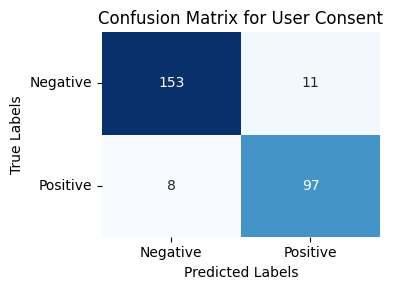

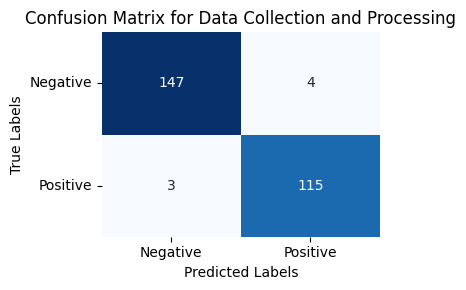

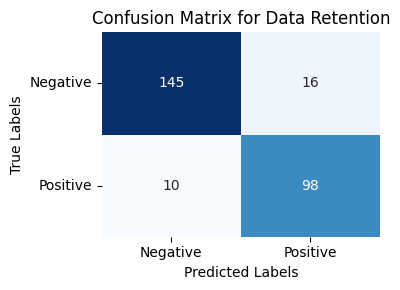

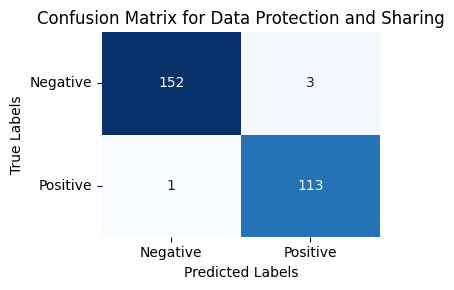

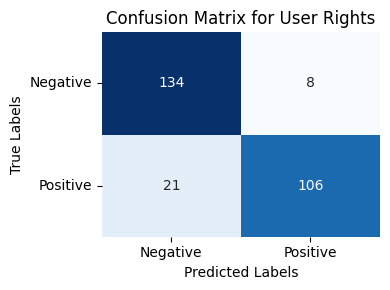

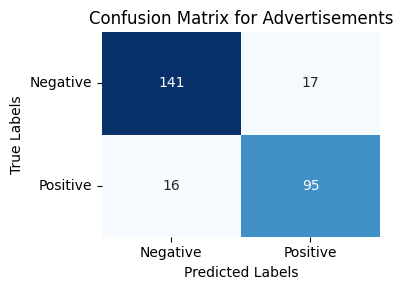

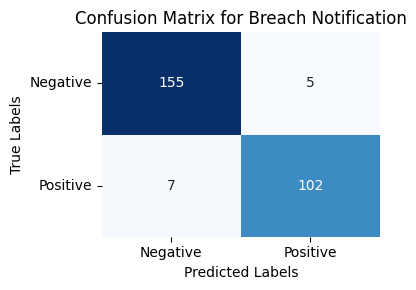

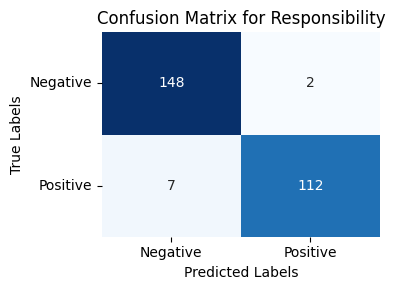

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'y_test_kf' are the true labels and 'y_pred_kf' are the predicted labels from your SVM classifier

# Calculate confusion matrices for each label
multilabel_cms = multilabel_confusion_matrix(y_test_kf, y_pred_kf)

# List of descriptive label names
label_names = [
    "User Consent",
    "Data Collection and Processing",
    "Data Retention",
    "Data Protection and Sharing",
    "User Rights",
    "Advertisements",
    "Breach Notification",
    "Responsibility"
]

# Plotting heatmaps for each label's confusion matrix
for i, label_name in enumerate(label_names):
    plt.figure(figsize=(4, 3))  # Adjusted figure size for better readability
    sns.heatmap(multilabel_cms[i], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {label_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks([0.5, 1.5], labels=['Negative', 'Positive'])  # Adjust labels as needed
    plt.yticks([0.5, 1.5], labels=['Negative', 'Positive'], rotation=0)  # Adjust rotation and labels
    plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
    plt.show()


In [ ]:
# Number of examples to print
n_examples = 5

# Iterate over the folds
for train_index, test_index in kf.split(X):
    examples_printed = 0  # Reset for each fold
    # Split data
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    # Transform the text data to TF-IDF features
    X_train_vec = vectorizer.fit_transform(X_train_kf)
    X_test_vec = vectorizer.transform(X_test_kf)

    # Fit the classifier
    classifier.fit(X_train_vec, y_train_kf)

    # Predict on the validation set
    y_pred_kf = classifier.predict(X_test_vec)

    # Iterate over the test set for the current fold
    for i, index in enumerate(test_index):
        # Only print n_examples
        if examples_printed >= n_examples:
            break

        # Select the i-th test example
        true_labels = y_test_kf.iloc[i, :]
        predicted_labels = y_pred_kf[i, :]

        # Check if the prediction does not match the true labels
        if not np.array_equal(true_labels, predicted_labels):
            print(f"Row Index: {index}")
            print(f"Text: {X_test_kf.iloc[i]}")
            print(f"True Labels: {true_labels.tolist()}")
            print(f"Pred Labels: {predicted_labels.tolist()}")
            print("\n")
            examples_printed += 1

Row Index: 23
Text: تصميم الموقع الالكتروني للشركه وفق اعلي معايير الامن السيبراني المعمول دوليا المملكه العربيه السعوديه تحرص شركه فينزي للتمويل المصغر الحصول المعلومات الضروريه فقط لتلبيه احتياجات العملاء الخدمات الالكترونيه المقدمه الموقع المعلومات الموجوده الموقع الالكتروني للشركه لغرض معلوماتي فقط ولايشكل عقد قانوني الشركه واي شخص جهه يحدد خلاف المعلومات المتوفره شركه فينزي للتمويل المصغر قابله للتغيير اشعار مسبق بالرغم اننا نبذل جهد لتحديث كافه المعلومات بصوره دايمه ودقيقه نستطيع نقدم ضمانات بذلك جمع واستخدام المعلومات الالكترونيه زياره موقعنا الالكتروني تقوم الشركه بالحصول معلومات شخصيه قمت باختيار خدمه التقديم الالكترونيه لاحد المنتجات زياراتك رسايل البريد الالكتروني رسايل البريد الالكتروني المرسله شركه فينزي للتمويل المصغر تعامل بنفس معامله الرسايل الخطيه ولن يتم مشاركه عناوين البريد الالكتروني يتم الحصول عليها الموقع الشركات الخاصه لاغراض تسويقيه نموذج الاقتراحات والشكاوي سيتم استخدام المعلومات المقدمه خلال النموذج فقط لتحسين خدمات شركه فينزي للتمويل المصغر وحل الشكاوي معلوما

# Machine Learning Models Word2vec

**word2vec Logistic Regression**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score
from gensim.models import Word2Vec

# Load the dataset
data = pd.read_csv('final_augmented_dataset_with_stop_words_without10_merge4,5.csv')

# Define the feature and target variables
X = data['col2']
label_cols = ['Label1', 'Label2', 'Label3', 'Label4', 'Label6', 'Label7', 'Label8', 'Label9']
y = data[label_cols]

# Prepare the text data for Word2Vec
sentences = [row.split() for row in X]

# Train a Word2Vec model (consider using a pre-trained model for better performance)
model = Word2Vec(sentences, vector_size=300, window=10, min_count=1, workers=4)

def document_vector(doc):
    """Create a document vector by averaging the Word2Vec vectors of its words."""
    words = doc.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(word_vectors, axis=0)

# Vectorize the documents using the document vector function
X_vec = np.array([document_vector(doc) for doc in X])

# Initialize the OneVsRestClassifier with Logistic Regression
classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear'))

# Define KFold cross-validator
kf = KFold(n_splits=7, random_state=42, shuffle=True)

# To store the F1 scores, precision, and recall for each label and their micro averages
f1_scores_labels = {label: [] for label in label_cols}
precision_scores_labels = {label: [] for label in label_cols}
recall_scores_labels = {label: [] for label in label_cols}
micro_f1_scores = []
micro_precision_scores = []
micro_recall_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X_vec):
    X_train_kf, X_test_kf = X_vec[train_index], X_vec[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    # Fit the classifier
    classifier.fit(X_train_kf, y_train_kf)

    # Predict on the validation set
    y_pred_kf = classifier.predict(X_test_kf)

    # Calculate metrics
    micro_f1 = f1_score(y_test_kf, y_pred_kf, average='micro')
    micro_precision = precision_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)
    micro_recall = recall_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)

    micro_f1_scores.append(micro_f1)
    micro_precision_scores.append(micro_precision)
    micro_recall_scores.append(micro_recall)

    for label_index, label in enumerate(label_cols):
        f1 = f1_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        precision = precision_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        recall = recall_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)

        f1_scores_labels[label].append(f1)
        precision_scores_labels[label].append(precision)
        recall_scores_labels[label].append(recall)

# Calculate and print the average metrics for each label
for label in label_cols:
    average_f1_score = np.mean(f1_scores_labels[label])
    average_precision_score = np.mean(precision_scores_labels[label])
    average_recall_score = np.mean(recall_scores_labels[label])

    print(f"Average F1 Score for {label}: {average_f1_score}")
    print(f"Average Precision Score for {label}: {average_precision_score}")
    print(f"Average Recall Score for {label}: {average_recall_score}")

# Calculate and print the average micro metrics across all cross-validation folds
average_micro_f1_score = np.mean(micro_f1_scores)
average_micro_precision_score = np.mean(micro_precision_scores)
average_micro_recall_score = np.mean(micro_recall_scores)

print(f"Average Micro F1 Score: {average_micro_f1_score}")
print(f"Average Micro Precision Score: {average_micro_precision_score}")
print(f"Average Micro Recall Score: {average_micro_recall_score}")


Average F1 Score for Label1: 0.8394674652395947
Average Precision Score for Label1: 0.8196632922741355
Average Recall Score for Label1: 0.8618716733530681
Average F1 Score for Label2: 0.9417791688823528
Average Precision Score for Label2: 0.9294131057362598
Average Recall Score for Label2: 0.9550985109918618
Average F1 Score for Label3: 0.7664606762942494
Average Precision Score for Label3: 0.8399331038136946
Average Recall Score for Label3: 0.7078400688925324
Average F1 Score for Label4: 0.9676551542346395
Average Precision Score for Label4: 0.9472361350187627
Average Recall Score for Label4: 0.9891262094319627
Average F1 Score for Label6: 0.7812854272643325
Average Precision Score for Label6: 0.7815516932614525
Average Recall Score for Label6: 0.7837218228265487
Average F1 Score for Label7: 0.803866771242184
Average Precision Score for Label7: 0.8212880218757636
Average Recall Score for Label7: 0.7895200004871658
Average F1 Score for Label8: 0.8772041174429901
Average Precision Score

**word2vec Random Forest**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score
from gensim.models import Word2Vec

# Load the dataset
data = pd.read_csv('final_augmented_dataset_with_stop_words_without10_merge4,5.csv')

# Define the feature and target variables
X = data['col2']
label_cols = ['Label1', 'Label2', 'Label3', 'Label4', 'Label6', 'Label7', 'Label8', 'Label9']
y = data[label_cols]

# Prepare the text data for Word2Vec
sentences = [row.split() for row in X]

# Train a Word2Vec model (consider using a pre-trained model for better performance)
model = Word2Vec(sentences, vector_size=300, window=10, min_count=1, workers=4)

def document_vector(doc):
    """Create a document vector by averaging the Word2Vec vectors of its words."""
    words = doc.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(word_vectors, axis=0)

# Vectorize the documents using the document vector function
X_vec = np.array([document_vector(doc) for doc in X])

# Initialize the OneVsRestClassifier with Random Forest
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=500, random_state=42))

# Define KFold cross-validator
kf = KFold(n_splits=7, random_state=42, shuffle=True)

# To store the F1 scores, precision, and recall for each label and their micro averages
f1_scores_labels = {label: [] for label in label_cols}
precision_scores_labels = {label: [] for label in label_cols}
recall_scores_labels = {label: [] for label in label_cols}
micro_f1_scores = []
micro_precision_scores = []
micro_recall_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X_vec):
    X_train_kf, X_test_kf = X_vec[train_index], X_vec[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    # Fit the classifier
    classifier.fit(X_train_kf, y_train_kf)

    # Predict on the validation set
    y_pred_kf = classifier.predict(X_test_kf)

    # Calculate metrics
    micro_f1 = f1_score(y_test_kf, y_pred_kf, average='micro')
    micro_precision = precision_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)
    micro_recall = recall_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)

    micro_f1_scores.append(micro_f1)
    micro_precision_scores.append(micro_precision)
    micro_recall_scores.append(micro_recall)

    for label_index, label in enumerate(label_cols):
        f1 = f1_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        precision = precision_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        recall = recall_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)

        f1_scores_labels[label].append(f1)
        precision_scores_labels[label].append(precision)
        recall_scores_labels[label].append(recall)

# Calculate and print the average metrics for each label
for label in label_cols:
    average_f1_score = np.mean(f1_scores_labels[label])
    average_precision_score = np.mean(precision_scores_labels[label])
    average_recall_score = np.mean(recall_scores_labels[label])

    print(f"Average F1 Score for {label}: {average_f1_score}")
    print(f"Average Precision Score for {label}: {average_precision_score}")
    print(f"Average Recall Score for {label}: {average_recall_score}")

# Calculate and print the average micro metrics across all cross-validation folds
average_micro_f1_score = np.mean(micro_f1_scores)
average_micro_precision_score = np.mean(micro_precision_scores)
average_micro_recall_score = np.mean(micro_recall_scores)

print(f"Average Micro F1 Score: {average_micro_f1_score}")
print(f"Average Micro Precision Score: {average_micro_precision_score}")
print(f"Average Micro Recall Score: {average_micro_recall_score}")


Average F1 Score for Label1: 0.8829625482965167
Average Precision Score for Label1: 0.8742251020565213
Average Recall Score for Label1: 0.8936120300485364
Average F1 Score for Label2: 0.9637499428106497
Average Precision Score for Label2: 0.9549223356487613
Average Recall Score for Label2: 0.9730588057705419
Average F1 Score for Label3: 0.8286236362372357
Average Precision Score for Label3: 0.8634511286130537
Average Recall Score for Label3: 0.7981584046854906
Average F1 Score for Label4: 0.9690189812331766
Average Precision Score for Label4: 0.9585582783302202
Average Recall Score for Label4: 0.9798097536456737
Average F1 Score for Label6: 0.8516924772901941
Average Precision Score for Label6: 0.8708874523435458
Average Recall Score for Label6: 0.8356986118499675
Average F1 Score for Label7: 0.856239369062328
Average Precision Score for Label7: 0.8754480414464029
Average Recall Score for Label7: 0.8400979087701671
Average F1 Score for Label8: 0.904503317097219
Average Precision Score 

**Word2vec Support Vector Machine**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score
from gensim.models import Word2Vec

# Load the dataset
data = pd.read_csv('final_augmented_dataset_with_stop_words_without10_merge4,5.csv')

# Define the feature and target variables
X = data['col2']
label_cols = ['Label1', 'Label2', 'Label3', 'Label4', 'Label6', 'Label7', 'Label8', 'Label9']
y = data[label_cols]

# Prepare the text data for Word2Vec
sentences = [row.split() for row in X]

# Train a Word2Vec model
model = Word2Vec(sentences, vector_size=300, window=10, min_count=1, workers=4)

def document_vector(doc):
    """Create a document vector by averaging the Word2Vec vectors of its words."""
    words = doc.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(word_vectors, axis=0)

# Vectorize the documents using the document vector function
X_vec = np.array([document_vector(doc) for doc in X])

# Initialize the OneVsRestClassifier with SVC
classifier = OneVsRestClassifier(SVC(kernel='linear',  probability=True, random_state=42))

# Define KFold cross-validator
kf = KFold(n_splits=7, random_state=42, shuffle=True)

# To store the F1 scores, precision, and recall for each label and their micro averages
f1_scores_labels = {label: [] for label in label_cols}
precision_scores_labels = {label: [] for label in label_cols}
recall_scores_labels = {label: [] for label in label_cols}
micro_f1_scores = []
micro_precision_scores = []
micro_recall_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X_vec):
    X_train_kf, X_test_kf = X_vec[train_index], X_vec[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    # Fit the classifier
    classifier.fit(X_train_kf, y_train_kf)

    # Predict on the validation set
    y_pred_kf = classifier.predict(X_test_kf)

    # Calculate metrics
    micro_f1 = f1_score(y_test_kf, y_pred_kf, average='micro')
    micro_precision = precision_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)
    micro_recall = recall_score(y_test_kf, y_pred_kf, average='micro', zero_division=0)

    micro_f1_scores.append(micro_f1)
    micro_precision_scores.append(micro_precision)
    micro_recall_scores.append(micro_recall)

    for label_index, label in enumerate(label_cols):
        f1 = f1_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        precision = precision_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)
        recall = recall_score(y_test_kf.iloc[:, label_index], y_pred_kf[:, label_index], average='binary', zero_division=0)

        f1_scores_labels[label].append(f1)
        precision_scores_labels[label].append(precision)
        recall_scores_labels[label].append(recall)

# Calculate and print the average metrics for each label
for label in label_cols:
    average_f1_score = np.mean(f1_scores_labels[label])
    average_precision_score = np.mean(precision_scores_labels[label])
    average_recall_score = np.mean(recall_scores_labels[label])

    print(f"Average F1 Score for {label}: {average_f1_score}")
    print(f"Average Precision Score for {label}: {average_precision_score}")
    print(f"Average Recall Score for {label}: {average_recall_score}")

# Calculate and print the average micro metrics across all cross-validation folds
average_micro_f1_score = np.mean(micro_f1_scores)
average_micro_precision_score = np.mean(micro_precision_scores)
average_micro_recall_score = np.mean(micro_recall_scores)

print(f"Average Micro F1 Score: {average_micro_f1_score}")
print(f"Average Micro Precision Score: {average_micro_precision_score}")
print(f"Average Micro Recall Score: {average_micro_recall_score}")


Average F1 Score for Label1: 0.8538703540913353
Average Precision Score for Label1: 0.8177169417424996
Average Recall Score for Label1: 0.8950532439025425
Average F1 Score for Label2: 0.9500111257269273
Average Precision Score for Label2: 0.9369488315854142
Average Recall Score for Label2: 0.9637519672079399
Average F1 Score for Label3: 0.7708491515536405
Average Precision Score for Label3: 0.8679725830164139
Average Recall Score for Label3: 0.6977569133503781
Average F1 Score for Label4: 0.9716900055290987
Average Precision Score for Label4: 0.9493165021107145
Average Recall Score for Label4: 0.9952007588371226
Average F1 Score for Label6: 0.7971353774525102
Average Precision Score for Label6: 0.781413608117831
Average Recall Score for Label6: 0.8162446493227041
Average F1 Score for Label7: 0.8131625870109651
Average Precision Score for Label7: 0.8272016614189264
Average Recall Score for Label7: 0.8023144290263814
Average F1 Score for Label8: 0.8828701412224101
Average Precision Score